In [10]:
import shap
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import boto3
import json
import random
import os

In [11]:
# AWS S3 Config
bucket_name = "mybucketnew1"
prefix = "consumer_data_with_algos/"
s3_client = boto3.client("s3", region_name=os.environ.get("AWS_REGION", "us-east-1"))

In [12]:
# Output Directory for Plots
output_dir = "/home/sagemaker-user/output"
os.makedirs(output_dir, exist_ok=True)

In [13]:
def get_random_file_from_s3():
    """Fetch a random file from S3."""
    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    files = [obj['Key'] for obj in response.get('Contents', [])]
    if not files:
        raise Exception("No files found in the specified S3 bucket/prefix.")
    random_file = random.choice(files)
    return random_file

In [14]:
def load_data_from_s3(file_key):
    """Load JSON data from the selected S3 file."""
    response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    data = json.loads(response['Body'].read())
    return data

In [15]:
def upload_to_s3(local_path, s3_path):
    """Upload a file to S3."""
    s3_client.upload_file(local_path, bucket_name, s3_path)
    print(f"Uploaded {local_path} to s3://{bucket_name}/{s3_path}")

In [16]:
def main():
    # Step 1: Fetch Data
    print("Fetching a random file from S3...")
    random_file = get_random_file_from_s3()
    print(f"Selected file: {random_file}")

    print("Loading data...")
    data = load_data_from_s3(random_file)

    # Step 2: Process Data
    print("Processing data...")
    df = pd.DataFrame(data)
    df = df[['market_cap', 'total_volume', 'current_price', 'price_change_24h']].dropna()

    X = df[['total_volume', 'current_price', 'price_change_24h']]
    y = df['market_cap']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 3: Train Model
    print("Training Random Forest Regressor...")
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Step 4: Explain Model
    print("Explaining the model with SHAP...")
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    # Step 5: Generate SHAP Summary Plot
    print("Generating SHAP summary plot...")
    summary_plot_path = os.path.join(output_dir, "shap_summary_plot.png")
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.savefig(summary_plot_path)
    print(f"SHAP summary plot saved at {summary_plot_path}")
    upload_to_s3(summary_plot_path, "plots/shap_summary_plot.png")

    # Step 6: Generate SHAP Force Plot
    print("Generating SHAP force plot...")
    force_plot_path = os.path.join(output_dir, "shap_force_plot.html")
    force_plot = shap.force_plot(
        explainer.expected_value,  # Fixed indexing issue
        shap_values[0].values,
        X_test.iloc[0, :],
        matplotlib=False
    )
    shap.save_html(force_plot_path, force_plot)
    print(f"SHAP force plot saved at {force_plot_path}")
    upload_to_s3(force_plot_path, "plots/shap_force_plot.html")

    # Step 7: Generate SHAP Dependence Plot
    print("Generating SHAP dependence plot...")
    dependence_plot_path = os.path.join(output_dir, "shap_dependence_plot_total_volume.png")
    shap.dependence_plot("total_volume", shap_values.values, X_test, show=False)
    plt.savefig(dependence_plot_path)
    print(f"SHAP dependence plot saved at {dependence_plot_path}")
    upload_to_s3(dependence_plot_path, "plots/shap_dependence_plot_total_volume.png")

    # Step 8: Cohort Analysis
    print("Performing cohort analysis...")
    high_market_cap = X_test[y_test > y_test.median()]
    low_market_cap = X_test[y_test <= y_test.median()]

    high_shap_values = explainer(high_market_cap)
    low_shap_values = explainer(low_market_cap)

    high_summary_plot_path = os.path.join(output_dir, "shap_high_market_cap_summary.png")
    shap.summary_plot(high_shap_values, high_market_cap, plot_type="bar", show=False)
    plt.savefig(high_summary_plot_path)
    print(f"High market cap summary plot saved at {high_summary_plot_path}")
    upload_to_s3(high_summary_plot_path, "plots/shap_high_market_cap_summary.png")

    low_summary_plot_path = os.path.join(output_dir, "shap_low_market_cap_summary.png")
    shap.summary_plot(low_shap_values, low_market_cap, plot_type="bar", show=False)
    plt.savefig(low_summary_plot_path)
    print(f"Low market cap summary plot saved at {low_summary_plot_path}")
    upload_to_s3(low_summary_plot_path, "plots/shap_low_market_cap_summary.png")

    # Step 9: Generate SHAP Waterfall Plot
    print("Generating SHAP waterfall plot...")
    waterfall_plot_path = os.path.join(output_dir, "shap_waterfall_plot.png")
    shap.plots.waterfall(shap_values[0])
    plt.savefig(waterfall_plot_path)
    print(f"SHAP waterfall plot saved at {waterfall_plot_path}")
    upload_to_s3(waterfall_plot_path, "plots/shap_waterfall_plot.png")

    print("Explainable AI processing completed.")

Fetching a random file from S3...
Selected file: consumer_data_with_algos/crypto_sample_35833.json
Loading data...
Processing data...
Training Random Forest Regressor...
Explaining the model with SHAP...
Generating SHAP summary plot...
SHAP summary plot saved at /home/sagemaker-user/output/shap_summary_plot.png
Uploaded /home/sagemaker-user/output/shap_summary_plot.png to s3://mybucketnew1/plots/shap_summary_plot.png
Generating SHAP force plot...
SHAP force plot saved at /home/sagemaker-user/output/shap_force_plot.html
Uploaded /home/sagemaker-user/output/shap_force_plot.html to s3://mybucketnew1/plots/shap_force_plot.html
Generating SHAP dependence plot...
SHAP dependence plot saved at /home/sagemaker-user/output/shap_dependence_plot_total_volume.png
Uploaded /home/sagemaker-user/output/shap_dependence_plot_total_volume.png to s3://mybucketnew1/plots/shap_dependence_plot_total_volume.png
Performing cohort analysis...
High market cap summary plot saved at /home/sagemaker-user/output/sh

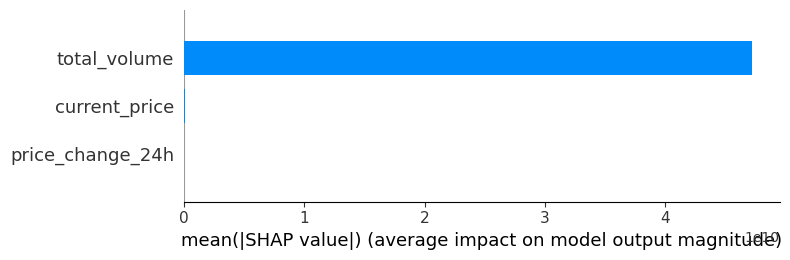

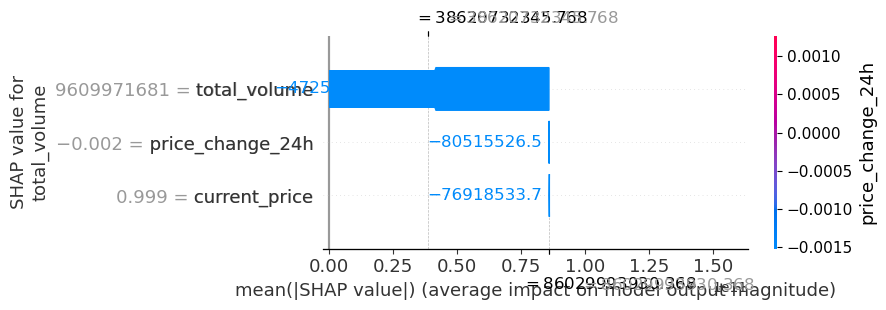

SHAP waterfall plot saved at /home/sagemaker-user/output/shap_waterfall_plot.png
Uploaded /home/sagemaker-user/output/shap_waterfall_plot.png to s3://mybucketnew1/plots/shap_waterfall_plot.png
Explainable AI processing completed.


<Figure size 640x480 with 0 Axes>

In [17]:
if __name__ == "__main__":
    main()